In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

In [242]:
def find_grid(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    # cv2.imshow('thresh', thresh)
    # RGB_img = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
    # plt.imshow(RGB_img)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    tiles = []
    max_area = 0
    count = 0

    # find the largest contour: assume to be the edge of the game board
    for c in contours:
        area = cv2.contourArea(c)
        if area > max_area:
            max_area = area
            best_cnt = c
            cv2.drawContours(image,[c],0,(0,255,0),3)
        count += 1

    # find contours within game board again
    mask = np.zeros((gray.shape), np.uint8)
    cv2.drawContours(mask,[best_cnt],0,255,-1)
    cv2.drawContours(mask,[best_cnt],0,0,2)


    return mask

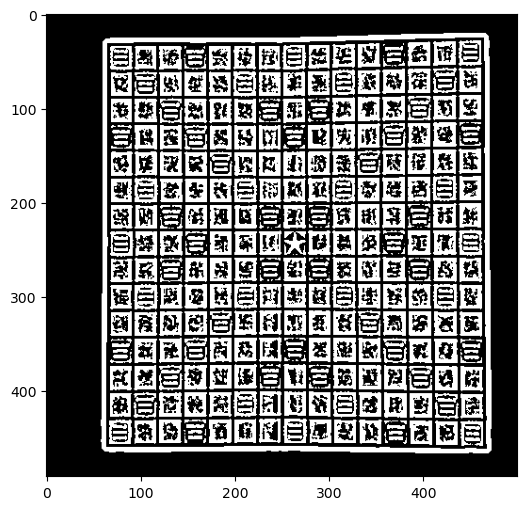

In [243]:
# detects 'data/board.jpeg' inner 25x25 grid
# detects 'data/board5.jpeg' inner 25x25 
# detects 'data/board3.jpeg' inner 25x25 grid
# when board is too contrasty with table detects the board grid
# NOT robust to occlusions

test_path = 'data/board5.jpeg'
test_img = cv2.imread(test_path)

m = find_grid(test_img)

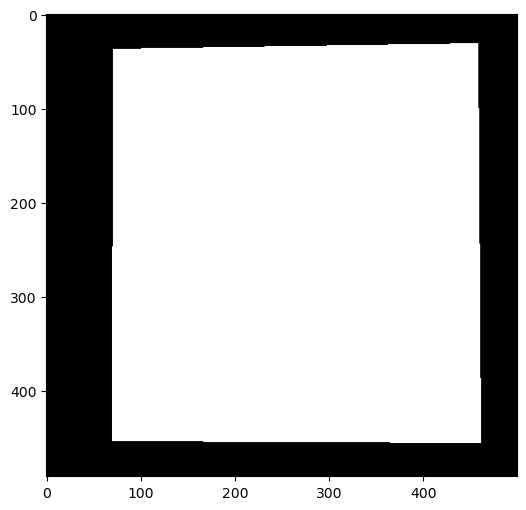

In [255]:
contours, _ = cv2.findContours(m, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

approx = cv2.approxPolyDP(contours[0], 0.02 * cv2.arcLength(contours[0], True), True)
if len(approx) == 4:
    cv2.drawContours(m, [approx], 0, (0, 255, 0), 3)

cv2.imshow('mask', m)
RGB_img = cv2.cvtColor(m, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

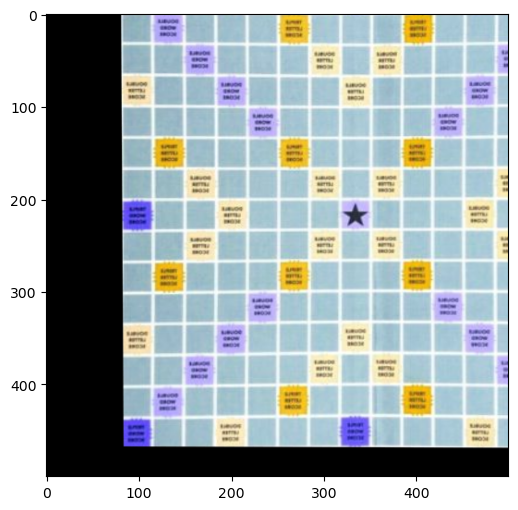

In [260]:
width = 500
height = 500

# extract corner points
pt1 = approx[0][0]
pt2 = approx[1][0]
pt3 = approx[2][0]
pt4 = approx[3][0]

# get highest and lowest x and y values
x_vals = [pt1[0], pt2[0], pt3[0], pt4[0]]
y_vals = [pt1[1], pt2[1], pt3[1], pt4[1]]

x_min = min(x_vals)
x_max = max(x_vals)
y_min = min(y_vals)
y_max = max(y_vals)

crop_width = x_max - x_min
crop_height = y_max - y_min

cropped_img = test_img[y_min:y_min+crop_height, x_min:x_min+crop_width]
plt.imshow(cropped_img)


# fix perspective warp
src_pts = np.float32([pt1, pt2, pt3, pt4])
dst_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
square_img = cv2.warpPerspective(cropped_img, M, (width, height), flags=cv2.INTER_AREA)

plt.imshow(square_img)


# Graveyard of bad ideas

Register the game board in image 

In [8]:
def find_squares(img):
    H, W, _ = img.shape
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur to the image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detect edges in the image using Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through each contour and determine if it's a square
    squares = []
    for c in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # If the polygon has 4 sides, it's a square
        if len(approx) == 4:
            # Get the coordinates of the square
            x, y, w, h = cv2.boundingRect(approx)
            # filter for squares > 50% of area
            if (h*w) / (H*W) > 0.5:
                squares.append((x, y, x + w, y + h))
            
    return squares

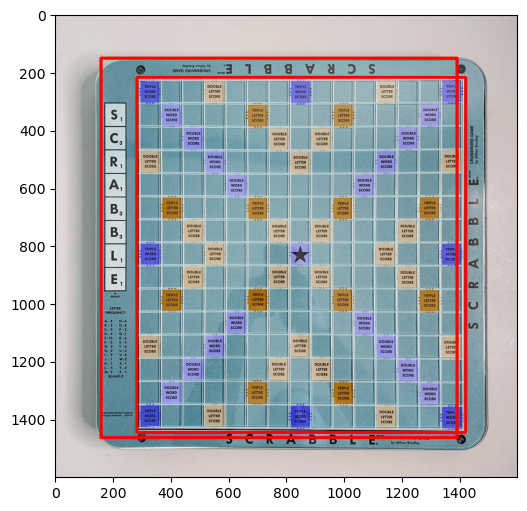

In [4]:
squares = find_squares(img)
# Draw rectangles around the squares in the image
for sq in squares:
    rect = cv2.rectangle(img, (sq[0], sq[1]), (sq[2], sq[3]), (255, 0, 0),10)
    plt.imshow(rect)

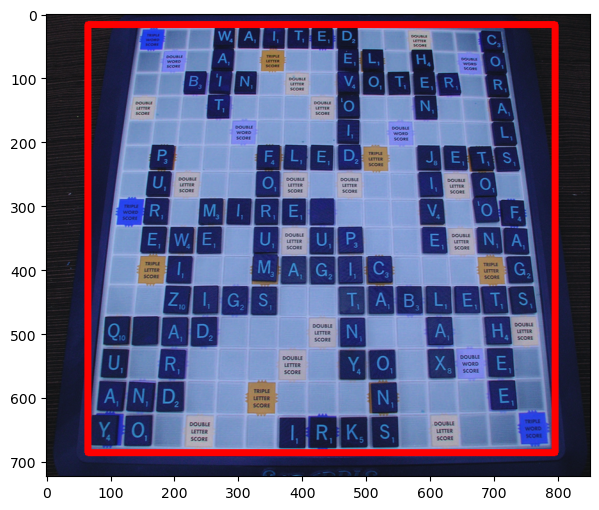

In [10]:
squares = find_squares(test_img)
# Draw rectangles around the squares in the image
for sq in squares:
    rect = cv2.rectangle(test_img, (sq[0], sq[1]), (sq[2], sq[3]), (255, 0, 0),10)
    plt.imshow(rect)

Cross register image to the template image

In [11]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
 
def alignImages(im1, im2):
 
  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
 
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
 
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
 
  # Sort matches by score
  matches = sorted(matches, key=lambda x: x.distance)
 
  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)
 
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
 
  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))
 
  return im1Reg, h

Hough transform to find lines

In [11]:
def findlines(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,100,150,apertureSize = 3)
    kernel = np.ones((3,3),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    kernel = np.ones((5,5),np.uint8)
    edges = cv2.erode(edges,kernel,iterations = 1)
    cv2.imwrite('canny.jpg',edges)

    lines = cv2.HoughLines(edges,1,np.pi/180,150)

    if not lines.any():
        print('No lines were found')
        exit()

    rho_threshold = 15
    theta_threshold = 0.1

    # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    print('number of Hough lines:', len(lines))

    filtered_lines = []
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))

    for line in filtered_lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    plt.imshow(img)